In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
dataset_folder = "datasets/financial"
# dataset_folder = "datasets/healthcare"
# dataset_folder = "datasets/eligibility"

# Init memories

In [3]:
import os

from cama.memory import WorkingMemory, EpisodicMemory, SemanticMemory
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import json

from docarray import BaseDoc, DocList
from typing import Tuple, List
from rich import print



df_reference = pd.read_csv(f"{dataset_folder}/initial.csv")
df_current = pd.read_csv(f"{dataset_folder}/drifted.csv")

with open(f'{dataset_folder}/dataset_description.json', 'r') as f:
    dataset_description = json.load(f)

# Split initial dataset into training and testing sets
label_name = dataset_description["LABEL"]
X_reference = df_reference.drop(columns=[label_name])
y_reference = df_reference[label_name]
X_train_reference, X_test_reference, y_train_reference, y_test_reference = train_test_split(X_reference, y_reference, test_size=0.2, random_state=42)

# Split drifted dataset into training and testing sets
X_current = df_current.drop(columns=[label_name])
y_current = df_current[label_name]
X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(X_current, y_current, test_size=0.2, random_state=42)

X_train_reference.head()

/home/guess/mambaforge/envs/dspy/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


,Age,Income,Credit Score,Loan Amount,Loan Term,Interest Rate,Employment Length,Home Ownership,Marital Status,Dependents
29,49,76048.805635,734,24149.221824,26,14.340610,25,1,2,3
535,50,85862.846339,643,19303.382431,37,16.488619,25,0,1,4
695,25,91801.131101,762,15226.356913,46,12.890015,25,1,1,2
557,48,95940.981754,662,29785.541561,43,16.984536,18,1,1,4
836,43,65028.359926,558,30045.986263,29,14.773979,26,1,1,3


In [4]:
from sklearn.ensemble import RandomForestClassifier

model_reference = RandomForestClassifier(random_state=42)
model_reference.fit(X_train_reference, y_train_reference)

# Test the model on the initial test set
initial_accuracy = model_reference.score(X_test_reference, y_test_reference)
print(f'Model trained and evaluated on the reference distribution: {initial_accuracy}')

Model trained and evaluated on the reference distribution: 0.91

## Episodic memory

In [5]:
from cama.memory import CurrentDataset


current_dataset = CurrentDataset(X=X_test_current, y_current=None, description=dataset_description)
first_episodic_memory = EpisodicMemory(current_dataset=current_dataset, task=0)
init_episodic_memory = DocList[EpisodicMemory]([first_episodic_memory])
# episodic_memory[0]


## Semantic memory

In [6]:
from cama.tools import get_tools
from cama.tools import get_drift_report, get_shap_values
from cama.memory import ReferenceDataset


tools = get_tools([get_drift_report, get_shap_values])


# At the beginning, the agent has 1 entry in the semantic memory. 
reference_dataset = ReferenceDataset(X_train=X_train_reference, 
                                     X_test=X_test_reference, 
                                     y_train=y_train_reference, 
                                     y_test=y_test_reference, 
                                     description=dataset_description)

init_semantic_memory = SemanticMemory(reference_dataset=reference_dataset, 
                                 tools=tools, model=model_reference)
# semantic_memory

## Dataset representation

In [7]:
from cama.representation import get_dataset_representation

get_drift_report_function = init_semantic_memory.tools['get_drift_report'].function
get_shap_values_report_function = init_semantic_memory.tools['get_shap_values'].function

drift_report = get_drift_report_function(init_semantic_memory.reference_dataset.description,
                                         init_semantic_memory.reference_dataset.X_train,
                                         init_episodic_memory[0].current_dataset.X,
                                         drift_share=0.7,
                                         show_plot=False)['drift_by_columns']

shap_report_train_reference = get_shap_values_report_function(init_semantic_memory.model,
                                                                init_semantic_memory.reference_dataset.X_train,
                                                                init_semantic_memory.reference_dataset.description)
shap_report_test_current = get_shap_values_report_function(init_semantic_memory.model,
                                                            init_episodic_memory[0].current_dataset.X,
                                                            init_episodic_memory[0].current_dataset.description)

shap_report = {feature: {'reference': shap_report_train_reference[feature], 'current': shap_report_test_current[feature]} for feature in shap_report_train_reference}
tools_results = {'get_drift_report': drift_report, 'get_shap_values': shap_report}


dataset_representation = get_dataset_representation(init_semantic_memory, tools_results)
# dataset_representation

# Generate/Load ground truth report

In [8]:
from cama.utils import get_ground_truth_template, generate_ground_truth_prompt

gt_template = get_ground_truth_template(init_semantic_memory,
                                        init_episodic_memory, 
                                        dataset_representation)
gt_prompt = generate_ground_truth_prompt(gt_template)
print(gt_prompt.format())

System: 
    You are an expert in data science and machine learning. Read the following report and complete it by filling 
inside the text '(Here the LLM should provide...)' with your explanations. Keep all the remaining text as it is.


# Comprehensive Report

## Executive Summary

(Here the LLM should provide an executive summary of the report.)

## Dataset Synopsis
**Title**: Loan Default Prediction Data  
**Features Analyzed**: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home 
Ownership, Marital Status, Dependents
**Label Variable**: Loan Default  

This dataset simulates the likelihood of borrowers defaulting on a loan based on attributes such as Age, 
Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home Ownership, Marital Status, and
Dependents. 
The 'Loan Default' variable serves as the label, indicating whether a borrower is likely (1) or not likely (0) to 
default on the loan. 


## Label Description
**Loan Default**: Indicates the likelihood of loan default, with 0 representing no default and 1 representing 
default.
(Here the LLM should provide an explanation if the label has issues or not. Remember that the label was not used in
the drift analysis and SHAP values.)

## Feature Analysis

### Feature name: Age
- **Description**: Age of the borrower in years, ranging from 18 to 70.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 70 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.03883719590118
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [27.0, 31.0, 35.0, 39.0, 43.0, 47.0, 51.0, 55.0, 59.0, 63.0, 67.0], 'y': 
[0.0025, 0.00375, 0.01625, 0.0175, 0.06125, 0.0575, 0.04125, 0.0325, 0.01125, 0.00625]}}
  - Reference: {'small_distribution': {'x': [18.0, 23.2, 28.4, 33.6, 38.8, 44.0, 49.2, 54.4, 59.6, 
64.80000000000001, 70.0], 'y': [0.00024038461538461543, 0.0007211538461538462, 0.00456730769230769, 
0.01418269230769232, 0.036298076923076905, 0.05697115384615382, 0.0432692307692308, 0.023076923076923064, 
0.010336538461538442, 0.002644230769230775]}}
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference distribution. Gives 
examples of the differences.)

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.08155174483476563 (Rank 3)
  - Current Data: 0.05350981388279517 (Rank 5)
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference SHAP values.)

#### Overal Interpretation**: 
  (Here the LLM should provide an overall interpretation for the feature: Age.)

### Feature name: Income
- **Description**: Annual income of the borrower in dollars, ranging from $20,000 to $150,000.
- **Type**: Numerical
- **Possible Values**: Ranging from $20,000 to $150,000.
- **Data Type**: float

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.130772018665271
- **Detection**: Drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [25501.45540738348, 37951.30986664513, 50401.164325906786, 
62851.01878516844, 75300.87324443008, 87750.72770369175, 100200.58216295339, 112650.43662221506, 125100.2910814767,
137550.14554073836, 150000.0], 'y': [8.03222241088998e-07, 6.024166808167485e-06, 6.024166808167485e-06, 
1.8072500424502464e-05, 1.405638921905745e-05, 1.0441889134156987e-05, 9.638666893067965e-06, 
6.8273890492564905e-06, 4.016111205444986e-06, 4.417722325989494e-06]}}
  - Reference: {'small_distribution': {'x': [20000.0, 32745.298315057298, 45490.596630114596, 58235.894945171895, 
70981.19326022919, 83726.49157528649, 96471.78989034379, 109217.08820540109, 121962.38652045839, 
134707.68483551568, 147452.98315057298], 'y': [3.923015277008463e-07, 1.9615076385042317e-06, 
7.944105935942136e-06, 1

In [9]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from cama.utils import generate_ground_truth_prompt
from cama.utils import extract_markdown
from cama.utils import save_to_file
from cama.utils import load_from_file

load_dotenv('env')

openai_llm = ChatOpenAI(temperature=0.7, model_name="gpt-4o", cache=False)
 
gt_prompt = generate_ground_truth_prompt(gt_template)


file_name = 'gt_report.md'
# Save to file if it doesn't exist
file_path = f'{dataset_folder}/{file_name}'

if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    gt_report = load_from_file(file_path)
else: 
    print(f"Invoking the pipeline to generate the ground truth report.")
    chain = gt_prompt | openai_llm | extract_markdown
    gt_report = chain.invoke({})#.content
    print(f"Saving the ground truth report to {file_path}")
    save_to_file(gt_report, file_path)

# print(gt_report)


datasets/financial/gt_report.md already exists. Loading from file.

# Generate/Load queries and answers

In [10]:
from cama.utils import generate_mchoice_qa_prompt, extract_json

number_qa = 40
qa_prompt = generate_mchoice_qa_prompt(gt_report, number_qa)
print(qa_prompt.format())

System: You are an expert in data science.
Human: 
    Generate 40 detailed multiple-choice questions and concise answers based on the following comprehensive report.
    Each question should have five options (A, B, C, D, E) and should cover various aspects of the report. Ensure 
the correct answer is clearly indicated and is unique. 
    Make sure to include numerical comparisons and insights drawn from the current and reference distributions 
wherever applicable:


    # Comprehensive Report

## Executive Summary

This report analyzes a dataset aimed at predicting loan defaults based on various borrower attributes. Key features
include Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home Ownership, 
Marital Status, and Dependents. The primary objective is to identify patterns and insights that can help in 
understanding the likelihood of loan defaults.

## Dataset Synopsis
**Title**: Loan Default Prediction Data  
**Features Analyzed**: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home 
Ownership, Marital Status, Dependents  
**Label Variable**: Loan Default  

This dataset simulates the likelihood of borrowers defaulting on a loan based on attributes such as Age, Income, 
Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home Ownership, Marital Status, and 
Dependents. The 'Loan Default' variable serves as the label, indicating whether a borrower is likely (1) or not 
likely (0) to default on the loan.

## Label Description
**Loan Default**: Indicates the likelihood of loan default, with 0 representing no default and 1 representing 
default.
(Here the LLM should provide an explanation if the label has issues or not. Remember that the label was not used in
the drift analysis and SHAP values.)

The label 'Loan Default' appears to be well-defined with clear binary outcomes (0 or 1). However, without using it 
in drift analysis and SHAP values, it’s crucial to ensure the consistency and accuracy of this label during model 
training and testing.

## Feature Analysis

### Feature name: Age
- **Description**: Age of the borrower in years, ranging from 18 to 70.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 70 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.03883719590118
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [27.0, 31.0, 35.0, 39.0, 43.0, 47.0, 51.0, 55.0, 59.0, 63.0, 67.0], 'y': 
[0.0025, 0.00375, 0.01625, 0.0175, 0.06125, 0.0575, 0.04125, 0.0325, 0.01125, 0.00625]}}
  - Reference: {'small_distribution': {'x': [18.0, 23.2, 28.4, 33.6, 38.8, 44.0, 49.2, 54.4, 59.6, 
64.80000000000001, 70.0], 'y': [0.00024038461538461543, 0.0007211538461538462, 0.00456730769230769, 
0.01418269230769232, 0.036298076923076905, 0.05697115384615382, 0.0432692307692308, 0.023076923076923064, 
0.010336538461538442, 0.002644230769230775]}}
  - Interpretation: The current distribution shows higher frequencies in the middle age ranges (35-55 years) 
compared to the reference distribution, which indicates a broader spread across all ages. This suggests a 
demographic shift in the current dataset towards middle-aged borrowers.

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.08155174483476563 (Rank 3)
  - Current Data: 0.05350981388279517 (Rank 5)
  - Interpretation: The SHAP values indicate that age was a significant factor during training (Rank 3) but has 
reduced in importance in the current data (Rank 5). This could imply changes in other influential factors or a 
shift in the borrowing population's characteristics.

#### Overall Interpretation: 
  Age does not show significant distribution drift, indicating stability in the age demographics of borrowers. 
However, its reduced importance in the current data suggests that while it remains relevant

In [11]:
from cama.utils import save_json_to_file, load_from_json

# chain = qa_prompt | openai_llm | extract_json

file_path = f'{dataset_folder}/qa_list.json'
if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    qa_list = load_from_json(file_path)
else:
    print(f"Invoking the pipeline to generate the QA list.")
    chain = qa_prompt | openai_llm | extract_json
    qa_list = chain.invoke({})
    print(f"Saving the QA list to {file_path}")
    save_json_to_file(qa_list, file_path)

len(qa_list)

datasets/financial/qa_list.json already exists. Loading from file.

datasets/financial/qa_list.json object loaded successfully

39

## CAMA report/answers

In [12]:
from cama.decision import DecisionProcedure
from langchain_community.chat_models import ChatOllama
from langchain_community.llms import Ollama
from langchain_groq import ChatGroq
from cama.utils import print_function_name
from dotenv import load_dotenv


load_dotenv('env')
llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"
# llm_name = "mixtral-8x7b-32768"
# llm_name = "gemma-7b-it"

# llm_name = "phi3:14b"
# llm_name = "phi3"

llm_generator = ChatGroq(cache=False, temperature=0.0, model_name=llm_name)
# llm_generator = ChatOllama(model=llm_name, cache=False, temperature=0.0)  #
llm_generator

ChatGroq(cache=False, client=<groq.resources.chat.completions.Completions object at 0x7f2e9e863b50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f2ea19bd850>, model_name='llama3-8b-8192', temperature=1e-08, groq_api_key=SecretStr('**********'))

In [13]:
from cama.utils import save_to_file

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Monitoring"

# eligibilit threshold = 0.70
# healthcare threshold = 0.65
# finance threshold = 0.35

working_memory = WorkingMemory(episodic_memory=init_episodic_memory, 
                              semantic_memory=init_semantic_memory, 
                              threshold=0.35, generations={})

decision_procedure = DecisionProcedure(llm_generator, debug=False)

# If slow_tools, episodic_memory, or semantic_memory or dataset representation exist in disk laod them
slow_tools_filename = f'{dataset_folder}/slow_tools_{llm_name}.pkl'
episodic_memory_filename = f'{dataset_folder}/episodic_memory_{llm_name}.pkl'
semantic_memory_filename = f'{dataset_folder}/semantic_memory_{llm_name}.pkl'
dataset_representation_filename = f'{dataset_folder}/dataset_representation_{llm_name}.pkl'

if os.path.exists(slow_tools_filename) and \
    os.path.exists(episodic_memory_filename) and \
    os.path.exists(semantic_memory_filename) and \
    os.path.exists(dataset_representation_filename) and \
    os.path.exists(f'{dataset_folder}/cama_agent_report_{llm_name}.md'):
    print("Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.")
    with open(slow_tools_filename, 'rb') as f:
        slow_tools_results = pickle.load(f)
    with open(episodic_memory_filename, 'rb') as f:
        episodic_memory = pickle.load(f)
    with open(semantic_memory_filename, 'rb') as f:
        semantic_memory = pickle.load(f)
    with open(dataset_representation_filename, 'rb') as f:
        dataset_representation = pickle.load(f)

    # load cama agent report
    cama_agent_report = episodic_memory.deep_insight.generate_markdown_report()
else:
    print("Running the decision procedure.")
    output = decision_procedure.run(working_memory)

    slow_tools_results = output['compile']['slow_tools_results']
    last_episodic_memory = output['compile']['episodic_memory'][-1]
    semantic_memory = output['compile']['semantic_memory']
    dataset_representation = output['compile']['dataset_representation']

    with open(slow_tools_filename, 'wb') as f:
        pickle.dump(slow_tools_results, f)
    with open(episodic_memory_filename, 'wb') as f:
        pickle.dump(last_episodic_memory, f)
    with open(semantic_memory_filename, 'wb') as f:
        pickle.dump(semantic_memory, f)
    with open(dataset_representation_filename, 'wb') as f:
        pickle.dump(dataset_representation, f)
    
    cama_agent_report = last_episodic_memory.deep_insight.generate_markdown_report()
    save_to_file(cama_agent_report, f'{dataset_folder}/cama_agent_report_{llm_name}.md')

    print("Slow tools, episodic_memory, semantic_memory, and dataset_representation saved to disk.")


Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.

In [14]:
from cama.utils import get_answers_from_report_prompt

get_answer_prompt = get_answers_from_report_prompt(cama_agent_report, qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:


        # Loan Default Prediction Data - Deep Insight Report

        ## Overview
        **Summary**

The Loan Default Prediction Data dataset contains 10 features and 1 label, 'Loan Default', which indicates the 
likelihood of a borrower defaulting on a loan. The features include Age, Income, Credit Score, Loan Amount, Loan 
Term, Interest Rate, Employment Length, Home Ownership, Marital Status, and Dependents. The analysis reveals that:

* The 'Income' feature shows significant drift, indicating a change in its distribution between the reference and 
current datasets.
* The 'Marital Status' feature also shows significant drift, suggesting that the model may need to be updated to 
account for changes in this feature.
* The 'Dependents' feature shows moderate drift, indicating a moderate level of change in its distribution.
* The 'Interest Rate' feature shows drift, indicating a change in its distribution between the reference and 
current datasets.
* The 'Employment Length' feature shows drift, indicating a change in its distribution between the reference and 
current datasets.
* The 'Home Ownership' feature shows significant drift, indicating a change in its distribution between the 
reference and current datasets.

**Conclusion**

The analysis of the Loan Default Prediction Data dataset reveals that several features show significant drift, 
indicating changes in their distributions between the reference and current datasets. These changes may impact the 
model's performance and accuracy. To address these changes, it is recommended to:

* Update the model to account for changes in the 'Marital Status' feature.
* Update the model to account for changes in the 'Home Ownership' feature.
* Monitor the distribution of the 'Interest Rate' feature to ensure it remains stable.
* Monitor the distribution of the 'Employment Length' feature to ensure it remains stable.
* Consider re-training the model to account for changes in the 'Dependents' feature.

By addressing these changes, the model can be updated to better predict loan defaults and improve its overall 
performance.

        ## Details

        ### Label Insight
        Based on the provided information, I will explain the label 'Loan Default' as follows:

The 'Loan Default' label is a categorical variable that indicates the likelihood of a borrower defaulting on a 
loan. The label takes on two possible values: 0 and 1.

* A value of 0 represents that the borrower is not likely to default on the loan, i.e., there is no default.
* A value of 1 represents that the borrower is likely to default on the loan, i.e., there is a default.

The label is an integer variable, which means it can take on integer values, in this case, 0 or 1. The possible 
values for the label are 'No default' and 'Default', respectively.

In summary, the 'Loan Default' label is a categorical variable that indicates the likelihood of a borrower 
defaulting on a loan, with 0 representing no default and 1 representing default.

There are no apparent problems or issues with the label based on the provided information.


            ### Age

            **Feature: Age**

The 'Age' feature represents the age of the borrower in years, ranging from 18 to 70. This feature is numerical in 
nature.

**Get Drift Report:**

The drift report for the 'Age' feature indicates that the distribution of the data has not changed significantly 
between the reference and current datasets. The drift score is 0.03883719590118, which is below the threshold of 
0.1. This suggests that the distribution of the 'Age' feature has not drifted significantly.

**Get Shap Values:**

The SHAP values for the 'Age' feature indicate that

In [15]:
method_name = "cama_agent"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename


'datasets/financial/answers_cama_agent_llama3-8b-8192.json'

In [16]:
# Invoke chain only if file does not exist
answers_cama_filename = f'{dataset_folder}/answers_cama_agent_{llm_name}.json'

if not os.path.exists(answers_cama_filename):
    print(f"Invoking the pipeline to get answers from the Cama Agent report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_cama_agent_report = chain.invoke({})
    save_json_to_file(answers_cama_agent_report, answers_cama_filename)
    
else:
    print(f"{answers_cama_filename} already exists. Loading from file.")
    answers_cama_agent_report = load_from_json(answers_cama_filename)

print(answers_cama_agent_report)

datasets/financial/answers_cama_agent_llama3-8b-8192.json already exists. Loading from file.

datasets/financial/answers_cama_agent_llama3-8b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': 'B'},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {'question': 'Which statistical test is used for distribution drift analysis in this report?', 'answer': 'D'},
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': 'C'},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': 'C'},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': 'B'
    },
    {'question': 'Which feature has the lowest SHAP value in both training and current data?', 'answer': 'A'},
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': 'A'},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': 'A'
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': 'C'},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'C'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': 'A'},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': 'B'},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': 'E'},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': 'A'
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': 'D'
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': 'C'
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': 'D'},
    {
        'question': 'Which feature shows no significant drift and consistent SHAP values in predicting loan 
defaults?',
        'answer': 'C'
    },
    {
        'question': "Which feature is describe

## Only Prompt

In [17]:
from cama.utils import generate_only_prompt_report_prompt
from cama.utils import generate_only_prompt_cot_report_prompt
from cama.utils import save_to_file


# print(report_prompt.format())
method_name = "full_prompt"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'
if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
    chain = report_prompt | llm_generator
    full_prompt_report = chain.invoke({}).content
    save_to_file(full_prompt_report, report_filename)

print(full_prompt_report)

datasets/financial/full_prompt_report_llama3-8b-8192.md already exists. Loading from file.

**Executive Summary**
=====================

The dataset provided contains information about borrowers and their likelihood of defaulting on a loan. The dataset
includes 11 features: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home 
Ownership, Marital Status, Dependents, and Loan Default. The dataset is simulated to test the performance of 
machine learning models in predicting loan default.

**Dataset Synopsis**
-------------------

* **Features:** 11 categorical and numerical features
* **Target Variable:** Loan Default (0 = no default, 1 = default)
* **Data Type:** Categorical and numerical
* **Description:** The dataset simulates the likelihood of borrowers defaulting on a loan based on attributes such 
as Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home Ownership, Marital 
Status, and Dependents.

**Tools Analysis**
-------------------

* **NUM_SAMPLES:** 1000
* **FEATURES:** ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Loan Term', 'Interest Rate', 'Employment Length',
'Home Ownership', 'Marital Status', 'Dependents']
* **NUMERICAL_FEATURES:** ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Loan Term', 'Interest Rate', 
'Employment Length']
* **CATEGORICAL_FEATURES:** ['Home Ownership', 'Marital Status', 'Dependents']
* **LABEL:** 'Loan Default'
* **COLUMN_TYPES:** Dictionary of column types (e.g., int, float, categorical)
* **COLUMN_VALUES:** Dictionary of column values (e.g., Age: 'Ranging from 18 to 70 years.')

**Conclusion**
----------

The dataset provides a comprehensive set of features to predict loan default. The tools analysis provides insights 
into the distribution of the data, including the number of samples, features, and data types. The dataset is 
suitable for testing machine learning models and can be used to develop predictive models for loan default.

In [18]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_report, 
                                                  qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Executive Summary**
=====================

The dataset provided contains information about borrowers and their likelihood of defaulting on a loan. The dataset
includes 11 features: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home 
Ownership, Marital Status, Dependents, and Loan Default. The dataset is simulated to test the performance of 
machine learning models in predicting loan default.

**Dataset Synopsis**
-------------------

* **Features:** 11 categorical and numerical features
* **Target Variable:** Loan Default (0 = no default, 1 = default)
* **Data Type:** Categorical and numerical
* **Description:** The dataset simulates the likelihood of borrowers defaulting on a loan based on attributes such 
as Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home Ownership, Marital 
Status, and Dependents.

**Tools Analysis**
-------------------

* **NUM_SAMPLES:** 1000
* **FEATURES:** ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Loan Term', 'Interest Rate', 'Employment Length',
'Home Ownership', 'Marital Status', 'Dependents']
* **NUMERICAL_FEATURES:** ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Loan Term', 'Interest Rate', 
'Employment Length']
* **CATEGORICAL_FEATURES:** ['Home Ownership', 'Marital Status', 'Dependents']
* **LABEL:** 'Loan Default'
* **COLUMN_TYPES:** Dictionary of column types (e.g., int, float, categorical)
* **COLUMN_VALUES:** Dictionary of column values (e.g., Age: 'Ranging from 18 to 70 years.')

**Conclusion**
----------

The dataset provides a comprehensive set of features to predict loan default. The tools analysis provides insights 
into the distribution of the data, including the number of samples, features, and data types. The dataset is 
suitable for testing machine learning models and can be used to develop predictive models for loan default.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categorical, C) Ordinal, D) Binary, E) 
Continuous
Which feature shows the most significant drift in the report? Options: A) Age, B) Credit Score, C) Marital Status, 
D) Loan Amount, E) Loan Term
What is the maximum value for the Credit Score feature? Options: A) 700, B) 800, C) 850, D) 900, E) 950
Which feature's current distribution indicates higher frequencies in the middle age ranges? Options: A) Income, B) 
Age, C) Credit Score, D) Loan Term, E) Interest Rate
Which feature has the lowest SHAP value in both training and current data? Options: A) Home Ownership, B) 
Dependents, C) Marital Status, D) Interest Rate, E) Loan Term
Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)? Options: A) D

In [19]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_full_prompt_llama3-8b-8192.json'

In [20]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the only prompt report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt = chain.invoke({})
    save_json_to_file(answers_full_prompt, answers_method_filename)
    print(answers_full_prompt)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt = load_from_json(answers_method_filename)
    print(answers_full_prompt)

datasets/financial/answers_full_prompt_llama3-8b-8192.json already exists. Loading from file.

datasets/financial/answers_full_prompt_llama3-8b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'What method is used for feature attribution analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'C'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range 

## Only Prompt + Chain of Thoghts

In [21]:
report_prompt = generate_only_prompt_cot_report_prompt(semantic_memory.reference_dataset.description, 
                                                   slow_tools_results)

# print(report_prompt.format())

method_name = "full_prompt_cot"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_cot_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    chain = report_prompt | llm_generator
    full_prompt_cot_report = chain.invoke({}).content
    save_to_file(full_prompt_cot_report, report_filename)

print(full_prompt_cot_report)

datasets/financial/full_prompt_cot_report_llama3-8b-8192.md already exists. Loading from file.

Here is the report in markdown format:

**Executive Summary**
=====================

The dataset provided contains information about borrowers and their likelihood of defaulting on a loan. The dataset
includes 11 features: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home 
Ownership, Marital Status, Dependents, and Loan Default. The dataset is used to predict the likelihood of loan 
default.

**Dataset Synopsis**
==================

The dataset contains 1000 samples, with each sample representing a borrower. The features are:

* **Numerical Features**: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length
* **Categorical Features**: Home Ownership, Marital Status, Dependents
* **Label**: Loan Default (0 for no default, 1 for default)

**Tools Analysis**
================

The dataset was analyzed using various tools to identify potential drifts in the data. The results are as follows:

* **Drift Detection**: The Kullback-Leibler divergence test was used to detect drifts in the data. The results show
that the following features have significant drifts:
        + Age
        + Credit Score
        + Employment Length
        + Income
        + Interest Rate
        + Loan Amount
        + Loan Term
* **Shap Values**: The SHAP values were calculated to analyze the importance of each feature in predicting loan 
default. The results show that the most important features are:
        + Income
        + Loan Term
        + Age
        + Credit Score
        + Employment Length

**Conclusion**
=============

The analysis of the dataset reveals significant drifts in several features, indicating changes in the underlying 
distribution of the data. The SHAP values highlight the importance of certain features in predicting loan default. 
These findings can be used to improve the accuracy of loan default prediction models.

In [22]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_cot_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    Here is the report in markdown format:

**Executive Summary**
=====================

The dataset provided contains information about borrowers and their likelihood of defaulting on a loan. The dataset
includes 11 features: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home 
Ownership, Marital Status, Dependents, and Loan Default. The dataset is used to predict the likelihood of loan 
default.

**Dataset Synopsis**
==================

The dataset contains 1000 samples, with each sample representing a borrower. The features are:

* **Numerical Features**: Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length
* **Categorical Features**: Home Ownership, Marital Status, Dependents
* **Label**: Loan Default (0 for no default, 1 for default)

**Tools Analysis**
================

The dataset was analyzed using various tools to identify potential drifts in the data. The results are as follows:

* **Drift Detection**: The Kullback-Leibler divergence test was used to detect drifts in the data. The results show
that the following features have significant drifts:
        + Age
        + Credit Score
        + Employment Length
        + Income
        + Interest Rate
        + Loan Amount
        + Loan Term
* **Shap Values**: The SHAP values were calculated to analyze the importance of each feature in predicting loan 
default. The results show that the most important features are:
        + Income
        + Loan Term
        + Age
        + Credit Score
        + Employment Length

**Conclusion**
=============

The analysis of the dataset reveals significant drifts in several features, indicating changes in the underlying 
distribution of the data. The SHAP values highlight the importance of certain features in predicting loan default. 
These findings can be used to improve the accuracy of loan default prediction models.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categorical, C) Ordinal, D) Binary, E) 
Continuous
Which feature shows the most significant drift in the report? Options: A) Age, B) Credit Score, C) Marital Status, 
D) Loan Amount, E) Loan Term
What is the maximum value for the Credit Score feature? Options: A) 700, B) 800, C) 850, D) 900, E) 950
Which feature's current distribution indicates higher frequencies in the middle age ranges? Options: A) Income, B) 
Age, C) Credit Score, D) Loan Term, E) Interest Rate
Which feature has the lowest SHAP value in both training and current data? Options: A) Home Ownership, B) 
Dependents, C) Marital Status, D) Interest Rate, E) Loan Term
Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgag

In [23]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_full_prompt_cot_llama3-8b-8192.json'

In [24]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the full prompt cot report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt_cot = chain.invoke({})
    save_json_to_file(answers_full_prompt_cot, answers_method_filename)
    print(answers_full_prompt_cot)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt_cot = load_from_json(answers_method_filename)
    print(answers_full_prompt_cot)


datasets/financial/answers_full_prompt_cot_llama3-8b-8192.json already exists. Loading from file.

datasets/financial/answers_full_prompt_cot_llama3-8b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {'question': 'Which statistical test is used for distribution drift analysis in this report?', 'answer': 'D'},
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': 'A'
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': "I DON'T KNOW"},
    {
    

## Reflection method

In [25]:
from cama.utils import ReflectionReportGenerator
from cama.utils import get_answers_from_report_prompt

# generator = ReflectionReportGenerator(llm_generator)
# report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
# print(report)

method_name = "reflection_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    reflection_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReflectionReportGenerator(llm_generator)
    reflection_report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
    save_to_file(reflection_report, report_filename)

print(reflection_report)

datasets/financial/reflection_report_llama3-8b-8192.md already exists. Loading from file.

Thank you for the detailed critique and recommendations. I will take them into consideration and improve the report
accordingly. Here is the revised report:

**Executive Summary**
=====================

The report presents an analysis of a loan default prediction dataset, which consists of 1000 samples with 11 
features and a target variable 'Loan Default'. The dataset is simulated to predict the likelihood of borrowers 
defaulting on a loan based on various attributes. The analysis reveals significant changes in the distribution of 
certain columns, indicating potential drift in the data. The SHAP values highlight the importance of certain 
features in predicting the target variable.

**Dataset Synopsis**
-------------------

### Dataset Overview

The dataset consists of 1000 samples with 11 features and a target variable 'Loan Default'. The target variable is 
a categorical variable indicating whether a borrower is likely (1) or not likely (0) to default on the loan.

### Features

The dataset includes the following features:

*   Age
*   Income
*   Credit Score
*   Loan Amount
*   Loan Term
*   Interest Rate
*   Employment Length
*   Home Ownership
*   Marital Status
*   Dependents

### Target Variable

The target variable 'Loan Default' is a categorical variable indicating whether a borrower is likely (1) or not 
likely (0) to default on the loan.

**Tools Analysis**
-----------------

### Drift Detection

The drift detection results show that there are significant changes in the distribution of the following columns:

*   Employment Length: The drift score is 0.10422809774139326, indicating a significant change in the distribution.
*   Income: The drift score is 0.130772018665271, indicating a significant change in the distribution.
*   Interest Rate: The drift score is 0.12211093048448328, indicating a significant change in the distribution.
*   Marital Status: The drift score is 5.655843738731566, indicating a significant change in the distribution.
*   Dependents: The drift score is 0.1290888567959812, indicating a significant change in the distribution.

### SHAP Values

The SHAP values show the contribution of each feature to the target variable 'Loan Default'. The top features 
contributing to the target variable are:

*   Income: The SHAP value is 0.1676025103420878, indicating a significant contribution to the target variable.
*   Loan Term: The SHAP value is 0.10786701225337081, indicating a moderate contribution to the target variable.
*   Age: The SHAP value is 0.08155174483476563, indicating a moderate contribution to the target variable.
*   Employment Length: The SHAP value is 0.07723764793746474, indicating a moderate contribution to the target 
variable.
*   Credit Score: The SHAP value is 0.057266813197127224, indicating a moderate contribution to the target 
variable.

**Conclusion**
==========

The analysis reveals significant changes in the distribution of certain columns, indicating potential drift in the 
data. The SHAP values highlight the importance of certain features in predicting the target variable. The results 
suggest that Income, Loan Term, Age, Employment Length, and Credit Score are the most important features 
contributing to the target variable.

I hope this revised report meets your expectations. Please let me know if there is anything else I can improve.

In [26]:
get_answer_prompt = get_answers_from_report_prompt(reflection_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    Thank you for the detailed critique and recommendations. I will take them into consideration and improve the 
report accordingly. Here is the revised report:

**Executive Summary**
=====================

The report presents an analysis of a loan default prediction dataset, which consists of 1000 samples with 11 
features and a target variable 'Loan Default'. The dataset is simulated to predict the likelihood of borrowers 
defaulting on a loan based on various attributes. The analysis reveals significant changes in the distribution of 
certain columns, indicating potential drift in the data. The SHAP values highlight the importance of certain 
features in predicting the target variable.

**Dataset Synopsis**
-------------------

### Dataset Overview

The dataset consists of 1000 samples with 11 features and a target variable 'Loan Default'. The target variable is 
a categorical variable indicating whether a borrower is likely (1) or not likely (0) to default on the loan.

### Features

The dataset includes the following features:

*   Age
*   Income
*   Credit Score
*   Loan Amount
*   Loan Term
*   Interest Rate
*   Employment Length
*   Home Ownership
*   Marital Status
*   Dependents

### Target Variable

The target variable 'Loan Default' is a categorical variable indicating whether a borrower is likely (1) or not 
likely (0) to default on the loan.

**Tools Analysis**
-----------------

### Drift Detection

The drift detection results show that there are significant changes in the distribution of the following columns:

*   Employment Length: The drift score is 0.10422809774139326, indicating a significant change in the distribution.
*   Income: The drift score is 0.130772018665271, indicating a significant change in the distribution.
*   Interest Rate: The drift score is 0.12211093048448328, indicating a significant change in the distribution.
*   Marital Status: The drift score is 5.655843738731566, indicating a significant change in the distribution.
*   Dependents: The drift score is 0.1290888567959812, indicating a significant change in the distribution.

### SHAP Values

The SHAP values show the contribution of each feature to the target variable 'Loan Default'. The top features 
contributing to the target variable are:

*   Income: The SHAP value is 0.1676025103420878, indicating a significant contribution to the target variable.
*   Loan Term: The SHAP value is 0.10786701225337081, indicating a moderate contribution to the target variable.
*   Age: The SHAP value is 0.08155174483476563, indicating a moderate contribution to the target variable.
*   Employment Length: The SHAP value is 0.07723764793746474, indicating a moderate contribution to the target 
variable.
*   Credit Score: The SHAP value is 0.057266813197127224, indicating a moderate contribution to the target 
variable.

**Conclusion**
==========

The analysis reveals significant changes in the distribution of certain columns, indicating potential drift in the 
data. The SHAP values highlight the importance of certain features in predicting the target variable. The results 
suggest that Income, Loan Term, Age, Employment Length, and Credit Score are the most important features 
contributing to the target variable.

I hope this revised report meets your expectations. Please let me know if there is anything else I can improve.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is u

In [27]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_reflection_report_llama3-8b-8192.json'

In [28]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/financial/answers_reflection_report_llama3-8b-8192.json already exists. Loading from file.

datasets/financial/answers_reflection_report_llama3-8b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': 'B'},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': 'C'},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'E'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': "I DON'T KNOW"},
    {
    

## React

In [29]:
from cama.utils import ReactReportGenerator

method_name = "react_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    react_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReactReportGenerator(llm_generator)
    react_report = generator.generate_report(description=semantic_memory.reference_dataset.description,
                                                   slow_tools_results=slow_tools_results)
    save_to_file(react_report, report_filename)

# print(react_report)

datasets/financial/react_report_llama3-8b-8192.md already exists. Loading from file.

In [30]:
get_answer_prompt = get_answers_from_report_prompt(react_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
You are an expert in data science. Read the following report carefully and answer the multiple-choice questions 
concisely. 
For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer should 
be I DON'T KNOW, do not make up answers.

Report:

The final answer is that the dataset has significant changes, and the features with the highest SHAP values are 
'Income', 'Loan Term', 'Employment Length', and 'Marital Status'.

Your output should be in json format (```json and ``` tags) as follows:

[
  {'question': 'copy the question here', 'answer': 'A'},
  {'question': 'copy the question here', 'answer': 'E'},
  ...
  {'question': 'copy the question here', 'answer': 'C'},
]

Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categorical, C) Ordinal, D) Binary, E) 
Continuous
Which feature shows the most significant drift in the report? Options: A) Age, B) Credit Score, C) Marital Status, 
D) Loan Amount, E) Loan Term
What is the maximum value for the Credit Score feature? Options: A) 700, B) 800, C) 850, D) 900, E) 950
Which feature's current distribution indicates higher frequencies in the middle age ranges? Options: A) Income, B) 
Age, C) Credit Score, D) Loan Term, E) Interest Rate
Which feature has the lowest SHAP value in both training and current data? Options: A) Home Ownership, B) 
Dependents, C) Marital Status, D) Interest Rate, E) Loan Term
Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)? Options: A) Dependents, B) Marital Status, C) 
Home Ownership, D) Loan Term, E) Employment Length
What is the minimum value for the Interest Rate feature? Options: A) 3.5%, B) 5%, C) 10%, D) 15%, E) 20%
Which feature had the most significant increase in SHAP value from training to current data? Options: A) Age, B) 
Income, C) Marital Status, D) Dependents, E) Home Ownership
What is the range of values for the Loan Term feature? Options: A) 6 to 48 months, B) 12 to 60 months, C) 18 to 72 
months, D) 24 to 84 months, E) 30 to 90 months
Which feature indicates the annual income of the borrower? Options: A) Age, B) Credit Score, C) Loan Amount, D) 
Income, E) Employment Length
Which feature showed significant drift and is now the second most important feature in current data? Options: A) 
Loan Term, B) Employment Length, C) Home Ownership, D) Marital Status, E) Interest Rate
What method is used for feature attribution analysis in this report? Options: A) LIME, B) Random Forest, C) 
Logistic Regression, D) Tree SHAP, E) KNN
Which feature represents the number of dependents of the borrower? Options: A) Loan Term, B) Interest Rate, C) 
Dependents, D) Marital Status, E) Employment Length
Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4? Options: A) Age, B) 
Income, C) Marital Status, D) Dependents, E) Home Ownership
What is the drift score for the Credit Score feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature's SHAP value indicated it was the third most significant factor during training? Options: A) Income, 
B) Age, C) Credit Score, D) Loan Term, E) Interest Rate
Which feature is represented as 0 (Single), 1 (Married

In [31]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_react_report_llama3-8b-8192.json'

In [32]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/financial/answers_react_report_llama3-8b-8192.json already exists. Loading from file.

datasets/financial/answers_react_report_llama3-8b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I 

## Self-Discover

In [33]:
from cama.utils import SelfDiscoverReportGenerator
from cama.utils import get_answers_from_report_prompt

# task_example = "Generate a comprehensive report on dataset changes, including an executive summary, dataset synopsis, detailed tools analysis, and conclusion. Use the provided dataset information and available tools to conduct your analysis."
report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
task = report_prompt.format()
reasoning_modules = [
    "1. How could I devise an experiment to help solve that problem?",
    "2. Make a list of ideas for solving this problem, and apply them one by one to the problem to see if any progress can be made.",
    "4. How can I simplify the problem so that it is easier to solve?",
    "5. What are the key assumptions underlying this problem?",
    "6. What are the potential risks and drawbacks of each solution?",
    "7. What are the alternative perspectives or viewpoints on this problem?",
    "8. What are the long-term implications of this problem and its solutions?",
    "9. How can I break down this problem into smaller, more manageable parts?",
    "10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.",
    "11. Try creative thinking, generate innovative and out-of-the-box ideas to solve the problem. Explore unconventional solutions, thinking beyond traditional boundaries, and encouraging imagination and originality.",
    "13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.",
    "14. Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions or approaches to a problem. Emphasize assessing the potential consequences and likelihood of success or failure, and making informed decisions based on a balanced analysis of risks and benefits.",
    "16. What is the core issue or problem that needs to be addressed?",
    "17. What are the underlying causes or factors contributing to the problem?",
    "18. Are there any potential solutions or strategies that have been tried before? If yes, what were the outcomes and lessons learned?",
    "19. What are the potential obstacles or challenges that might arise in solving this problem?",
    "20. Are there any relevant data or information that can provide insights into the problem? If yes, what data sources are available, and how can they be analyzed?",
    "21. Are there any stakeholders or individuals who are directly affected by the problem? What are their perspectives and needs?",
    "22. What resources (financial, human, technological, etc.) are needed to tackle the problem effectively?",
    "23. How can progress or success in solving the problem be measured or evaluated?",
    "24. What indicators or metrics can be used?",
    "25. Is the problem a technical or practical one that requires a specific expertise or skill set? Or is it more of a conceptual or theoretical problem?",
    "26. Does the problem involve a physical constraint, such as limited resources, infrastructure, or space?",
    "27. Is the problem related to human behavior, such as a social, cultural, or psychological issue?",
    "28. Does the problem involve decision-making or planning, where choices need to be made under uncertainty or with competing objectives?",
    "29. Is the problem an analytical one that requires data analysis, modeling, or optimization techniques?",
    "30. Is the problem a design challenge that requires creative solutions and innovation?",
    "31. Does the problem require addressing systemic or structural issues rather than just individual instances?",
    "32. Is the problem time-sensitive or urgent, requiring immediate attention and action?",
    "33. What kinds of solution typically are produced for this kind of problem specification?",
    "34. Given the problem specification and the current best solution, have a guess about other possible solutions.",
    "35. Let’s imagine the current best solution is totally wrong, what other ways are there to think about the problem specification?",
    "36. What is the best way to modify this current best solution, given what you know about these kinds of problem specification?",
    "37. Ignoring the current best solution, create an entirely new solution to the problem.",
    "39. Let’s make a step by step plan and implement it with good notation and explanation.",
]

# generator = SelfDiscoverReportGenerator(llm_generator)
# report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
# print(report)

In [34]:
from cama.utils import SelfDiscoverReportGenerator

method_name = "self_discover_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    self_discover_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = SelfDiscoverReportGenerator(llm_generator)
    self_discover_report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
    save_to_file(self_discover_report, report_filename)

datasets/financial/self_discover_report_llama3-8b-8192.md already exists. Loading from file.

In [35]:
get_answer_prompt = get_answers_from_report_prompt(self_discover_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Executive Summary**
The dataset provided is a loan default prediction dataset, which aims to predict the likelihood of borrowers 
defaulting on a loan based on various attributes such as Age, Income, Credit Score, Loan Amount, Loan Term, 
Interest Rate, Employment Length, Home Ownership, Marital Status, and Dependents.

**Dataset Synopsis**
The dataset consists of 1000 samples, with 10 features and 1 label. The features are:

* Age: ranging from 18 to 70 years
* Income: ranging from $20,000 to $150,000
* Credit Score: ranging from 300 to 850
* Loan Amount: ranging from $1,000 to $50,000
* Loan Term: ranging from 12 to 60 months
* Interest Rate: ranging from 3.5% to 25%
* Employment Length: ranging from 0 to 40 years
* Home Ownership: categorized as 0 (Rent), 1 (Own), or 2 (Mortgage)
* Marital Status: categorized as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)
* Dependents: ranging from 0 to 5

The label is "Loan Default", indicating whether a borrower is likely (1) or not likely (0) to default on the loan.

**Tools Analysis**
The tools results show that the dataset has the following characteristics:

* NUM_SAMPLES: 1000
* FEATURES: ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Loan Term', 'Interest Rate', 'Employment Length', 
'Home Ownership', 'Marital Status', 'Dependents']
* NUMERICAL_FEATURES: ['Age', 'Income', 'Credit Score', 'Loan Amount', 'Loan Term', 'Interest Rate', 'Employment 
Length']
* CATEGORICAL_FEATURES: ['Home Ownership', 'Marital Status', 'Dependents']
* LABEL: 'Loan Default'
* COLUMN_TYPES: {'Age': 'int', 'Income': 'float', 'Credit Score': 'int', 'Loan Amount': 'float', 'Loan Term': 
'int', 'Interest Rate': 'float', 'Employment Length': 'int', 'Home Ownership': 'int', 'Marital Status': 'int', 
'Dependents': 'int', 'Loan Default': 'int'}

**Conclusion**
The dataset provides a comprehensive set of features to predict loan default, including demographic and financial 
information. The tools analysis reveals the characteristics of the dataset, including the number of samples, 
features, and data types. The dataset can be used to develop a machine learning model to predict loan default.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categorical, C) Ordinal, D) Binary, E) 
Continuous
Which feature shows the most significant drift in the report? Options: A) Age, B) Credit Score, C) Marital Status, 
D) Loan Amount, E) Loan Term
What is the maximum value for the Credit Score feature? Options: A) 700, B) 800, C) 850, D) 900, E) 950
Which feature's current distribution indicates higher frequencies in the middle age ranges? Options: A) Income, B) 
Age, C) Credit Score, D) Loan Term, E) Inter

In [36]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_self_discover_report_llama3-8b-8192.json'

In [37]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/financial/answers_self_discover_report_llama3-8b-8192.json already exists. Loading from file.

datasets/financial/answers_self_discover_report_llama3-8b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': 'C'},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': 'B'
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': 'A'},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'What method is used for feature attribution analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'C'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': 'A'},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': 'D'
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': 'D'},

## Plan and Execute

In [38]:
from cama.utils import PlanAndExecuteReportGenerator
from cama.utils import get_answers_from_report_prompt
import textwrap

task = textwrap.dedent(f"""
    You are an expert in data science. Generate a comprehensive report that includes an executive summary, dataset synopsis, detailed tools analysis, and conclusion.  Use the provided dataset information and available tools to conduct your analysis.

    Dataset information:

    {semantic_memory.reference_dataset.description}

    """)


method_name = "plan_and_execute_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    plan_and_execute_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = PlanAndExecuteReportGenerator(llm=llm_generator)
    event = generator.generate_report(description=task, slow_tools_results=slow_tools_results)
    plan_and_execute_report = event['agent']['past_steps'][-1][1]
    save_to_file(plan_and_execute_report, report_filename)

datasets/financial/plan_and_execute_report_llama3-8b-8192.md already exists. Loading from file.

In [39]:
get_answer_prompt = get_answers_from_report_prompt(plan_and_execute_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Comprehensive Monitoring Report on Dataset Changes**

**Introduction**

This report provides an overview of the changes detected in the dataset over time. The analysis is based on the 
GetDriftReport and GetSHAPValues tools, which provide insights into the drift scores and SHAP values of the 
features in the dataset.

**Drift Detection**

The GetDriftReport tool was used to detect changes in the distribution of the features in the dataset. The results 
are presented in the table below:

| Column Name | Drift Score | Drift Detected |
| --- | --- | --- |
| Age | 0.03883719590118 | False |
| Credit Score | 0.0778065393961156 | False |
| Employment Length | 0.10422809774139326 | True |
| Income | 0.130772018665271 | True |
| Interest Rate | 0.12211093048448328 | True |
| Loan Amount | 0.06465984187565631 | False |
| Loan Term | 0.06991922445224397 | False |
| Home Ownership | 0.18557356469873026 | True |
| Marital Status | 5.655843738731566 | True |
| Dependents | 0.1290888567959812 | True |

The results show that the following columns have detected drift: Employment Length, Income, Interest Rate, Home 
Ownership, Marital Status, and Dependents.

**SHAP Values**

The GetSHAPValues tool was used to calculate the SHAP values for each feature in the dataset. The results are 
presented in the table below:

| Column Name | Reference Value | Current Value | Position |
| --- | --- | --- | --- |
| Income | 0.13983600738410132 | 0.1676025103420878 | 1 |
| Loan Term | 0.10786701225337081 | 0.08865791016936486 | 2 |
| Age | 0.08155174483476563 | 0.05350981388279517 | 5 |
| Employment Length | 0.07748587080834744 | 0.07723764793746474 | 3 |
| Credit Score | 0.057266813197127224 | 0.05259014360839969 | 6 |
| Marital Status | 0.041422401537971096 | 0.07354211915327408 | 4 |
| Loan Amount | 0.03091725874540736 | 0.030296443826883252 | 7 |
| Interest Rate | 0.02195194757664086 | 0.017982049611167866 | 9 |
| Dependents | 0.02095623100403098 | 0.01848637683404379 | 8 |
| Home Ownership | 0.003640297286226866 | 0.003270709366873879 | 10 |

The results show that the SHAP values have changed significantly for the following columns: Income, Loan Term, Age,
Employment Length, Credit Score, Marital Status, Loan Amount, Interest Rate, Dependents, and Home Ownership.

**Conclusion**

The analysis reveals that the dataset has undergone significant changes over time. The drift detection results show
that the distributions of the features have changed, and the SHAP values have also changed significantly. These 
changes may indicate that the underlying relationships between the features have changed, which may impact the 
accuracy of the models trained on this dataset. Further analysis and monitoring are recommended to understand the 
implications of these changes.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: 

In [40]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_plan_and_execute_report_llama3-8b-8192.json'

In [41]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)

print(answers_reflection)

datasets/financial/answers_plan_and_execute_report_llama3-8b-8192.json already exists. Loading from file.

datasets/financial/answers_plan_and_execute_report_llama3-8b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': 'B'},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': 'C'},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has the lowest SHAP value in both training and current data?', 'answer': 'A'},
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': 'C'
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': 'A'
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': 'C'
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': 'C'},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': 'D'
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'E'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': 'B'},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': 'E'},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': 'D'
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature shows no significant drift and consistent SHAP values in predicting loan 
defau

## Evaluation using multiple-choice questions

In [42]:
# load the answers from the json file
from cama.utils import load_from_json

# llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"


# dataset_folder = "datasets/healthcare"
# dataset_folder = "eligibility_dataset"

answers_cama_agent = load_from_json(f'{dataset_folder}/answers_cama_agent_{llm_name}.json')
answers_full_prompt = load_from_json(f'{dataset_folder}/answers_full_prompt_{llm_name}.json')
answers_full_prompt_cot = load_from_json(f'{dataset_folder}/answers_full_prompt_cot_{llm_name}.json')
answers_reflection = load_from_json(f'{dataset_folder}/answers_reflection_report_{llm_name}.json')
answers_react = load_from_json(f'{dataset_folder}/answers_react_report_{llm_name}.json')
answers_self_discover = load_from_json(f'{dataset_folder}/answers_self_discover_report_{llm_name}.json')
answers_plan_and_execute = load_from_json(f'{dataset_folder}/answers_plan_and_execute_report_{llm_name}.json')



# answers_reflection

datasets/financial/answers_cama_agent_llama3-8b-8192.json object loaded successfully

datasets/financial/answers_full_prompt_llama3-8b-8192.json object loaded successfully

datasets/financial/answers_full_prompt_cot_llama3-8b-8192.json object loaded successfully

datasets/financial/answers_reflection_report_llama3-8b-8192.json object loaded successfully

datasets/financial/answers_react_report_llama3-8b-8192.json object loaded successfully

datasets/financial/answers_self_discover_report_llama3-8b-8192.json object loaded successfully

datasets/financial/answers_plan_and_execute_report_llama3-8b-8192.json object loaded successfully

datasets/financial/qa_list.json object loaded successfully

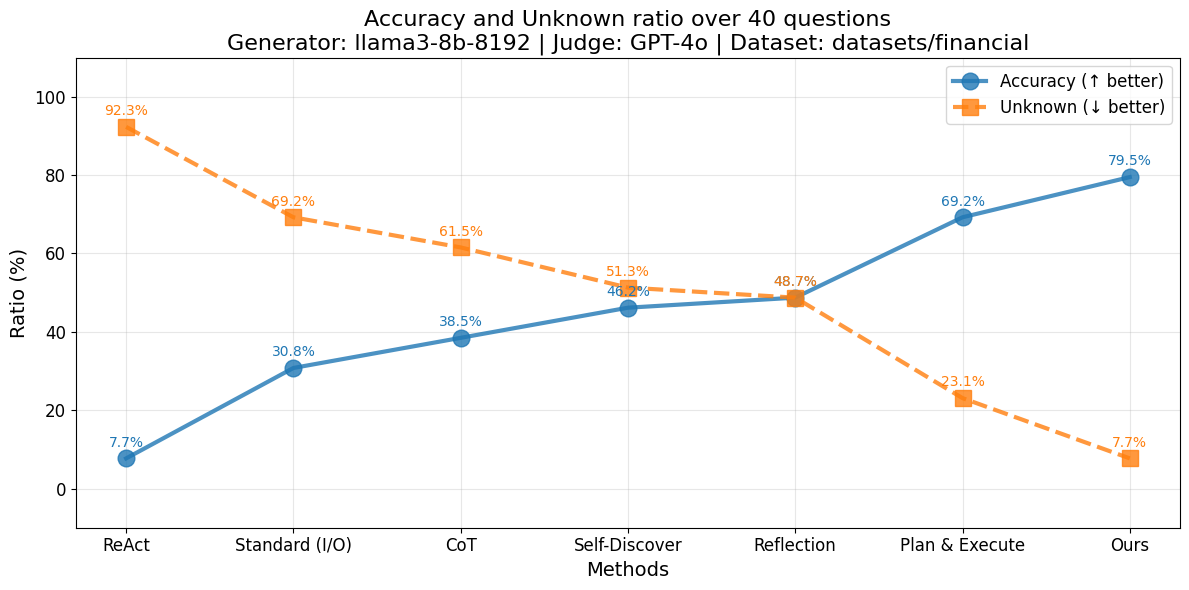

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple
from cama.utils import evaluate_answers_with_unknowns

# load qa list
qa_list = load_from_json(f'{dataset_folder}/qa_list.json')

def plot_scores_with_unknowns(scores: Dict[str, Tuple[float, float]], llm_name: str):
    """
    Creates a single line plot showing both accuracy scores and unknown ratios.

    Parameters:
    scores (Dict[str, Tuple[float, float]]): A dictionary where keys are method names and values are tuples (accuracy, unknown_ratio).
    llm_name (str): The name of the language model used as the report generator.
    """
    methods = list(scores.keys())
    accuracies = [score[0] for score in scores.values()]
    unknown_ratios = [score[1] for score in scores.values()]

    # Sort methods by accuracy for better visual trend
    sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k])
    methods = [methods[i] for i in sorted_indices]
    accuracies = [accuracies[i] for i in sorted_indices]
    unknown_ratios = [unknown_ratios[i] for i in sorted_indices]

    plt.figure(figsize=(12, 6))

    # Plot both lines on the same graph
    plt.plot(methods, accuracies, marker='o', linewidth=3, color='#1f77b4', markersize=12, label='Accuracy (↑ better)', alpha=0.8)
    plt.plot(methods, unknown_ratios, marker='s', linewidth=3, color='#ff7f0e', markersize=12, label='Unknown (↓ better)', alpha=0.8, linestyle='--')
    
    # Highlight CAMA with different markers
    # cama_index = methods.index("CAMA") if "CAMA" in methods else -1
    # if cama_index != -1:
    #     plt.plot(cama_index, accuracies[cama_index], marker='*', markersize=20, color='#1f77b4', label='CAMA (Acc)', linewidth=0)
    #     plt.plot(cama_index, unknown_ratios[cama_index], marker='P', markersize=20, color='#ff7f0e', label='CAMA (Unk)', linewidth=0)
    
    plt.ylim(-10, 110)
    plt.xlabel('Methods', fontsize=14)
    plt.ylabel('Ratio (%)', fontsize=14)
    plt.title(f'Accuracy and Unknown ratio over 40 questions\nGenerator: {llm_name} | Judge: GPT-4o | Dataset: {dataset_folder}', fontsize=16)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # # Create a custom legend order
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1]  # Accuracy, Unknown
    # if cama_index != -1:
    #     order.extend([2, 3])  # CAMA (Acc), CAMA (Unk)
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=12)

    # Add value labels on each point with offset for better readability
    for i, (acc, unk) in enumerate(zip(accuracies, unknown_ratios)):
        # if acc > unk:
        plt.text(i, acc + 3, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        plt.text(i, unk + 3, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')
        # else:
        #     plt.text(i, acc - 2, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        #     plt.text(i, unk + 2, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')

    # save plot in pdf
    # plt.savefig(f'{dataset_folder}/scores_plot_{llm_name}.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Example usage:
scores = {
    "Standard (I/O)": evaluate_answers_with_unknowns(qa_list, answers_full_prompt),
    "CoT": evaluate_answers_with_unknowns(qa_list, answers_full_prompt_cot),
    "Ours": evaluate_answers_with_unknowns(qa_list, answers_cama_agent),
    "Reflection": evaluate_answers_with_unknowns(qa_list, answers_reflection),
    "ReAct": evaluate_answers_with_unknowns(qa_list, answers_react),
    "Self-Discover": evaluate_answers_with_unknowns(qa_list, answers_self_discover),
    "Plan & Execute": evaluate_answers_with_unknowns(qa_list, answers_plan_and_execute),
}

plot_scores_with_unknowns(scores, llm_name)